# Predict Future Sale - Feature Engineering
## Final project for "How to win a data science competition" Coursera course
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data  
>Student: Rafael Caneiro de Oliveira  
>Email: rafael.caneiro@gmail.com  
>Date: 12/12/2020

## Load

In [113]:
import numpy as np
import pandas as pd
from itertools import product

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

PATH = Path.cwd().parent
DATA_PATH = Path(PATH, "./data/raw/") 
MODEL_PATH = Path(PATH, "./models/") 

seed = 42

In [114]:
sales = pd.read_csv(Path(DATA_PATH,"sales_train.csv"))
items = pd.read_csv(Path(DATA_PATH,"items.csv"))
categories = pd.read_csv(Path(DATA_PATH,"item_categories.csv"))
shops = pd.read_csv(Path(DATA_PATH,"shops.csv"))
test = pd.read_csv(Path(DATA_PATH,"test.csv"))
test["date_block_num"]=34

## Aggregate

In [115]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

shop_first_block = sales.groupby(["shop_id"], as_index=False)["date_block_num"].min()

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in shop_first_block['date_block_num'].unique():
    cur_shops = shop_first_block.loc[shop_first_block.date_block_num<=block_num, "shop_id"].values.tolist()
    cur_items = sales[sales.shop_id.isin(cur_shops)]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)
grid.shape

(15795594, 3)

In [116]:
# index_cols = ['shop_id', 'item_id', 'date_block_num']

# # For every month we create a grid from all shops/items combinations from that month
# grid = [] 
# for block_num in sales['date_block_num'].unique():
#     cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
#     cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
#     grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
# #turn the grid into pandas dataframe
# grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)
# grid.shape

In [117]:
#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':'sum'})

#fix column names
gb.rename({"item_cnt_day":"target"}, inplace=True, axis=1)

#join aggregated data to the grid
train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#sort the data
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
print(train.shape)

(15795594, 4)


## Join

In [118]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [119]:
train = train.merge(items, on="item_id", how="left")
train = train.merge(categories, on="item_category_id", how="left")
train = train.merge(shops, on="shop_id", how="left")
train.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
train = train[train.target>=0]
train.reset_index(drop=True, inplace=True)
# train = reduce_mem_usage(train)
print(train.shape)
train.head()

(15795240, 5)


,shop_id,item_id,date_block_num,target,item_category_id
0,0,0,0,0.0,40
1,0,2,0,0.0,40
2,0,3,0,0.0,40
3,0,4,0,0.0,40
4,0,5,0,0.0,40


In [120]:
train.target.mean()

0.10249018058604997

In [121]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,15795240.0,29.183406,17.674629,0.0,14.0,28.0,45.0,59.0
item_id,15795240.0,11155.191672,6362.467626,0.0,5661.0,11191.0,16663.0,22169.0
date_block_num,15795240.0,13.719435,9.521621,0.0,5.0,14.0,19.0,33.0
target,15795240.0,0.102490,1.753276,0.0,0.0,0.0,0.0,2253.0
item_category_id,15795240.0,46.206136,15.820097,0.0,37.0,40.0,58.0,83.0


In [122]:
test = test.merge(items, on="item_id", how="left")
test = test.merge(categories, on="item_category_id", how="left")
test = test.merge(shops, on="shop_id", how="left")
test.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
# test = reduce_mem_usage(test)
test.head()

,ID,shop_id,item_id,date_block_num,item_category_id
0,0,5,5037,34,19
1,1,5,5320,34,55
2,2,5,5233,34,19
3,3,5,5232,34,23
4,4,5,5268,34,20


## Test / Validation Split

In [123]:
def get_index(start, end, df, col):
    ls = [x for x in range(start , end + 1)]
    idx = df[df[col].isin(ls)].index.ravel()
    return idx

# 2013-jan >> 2013-oct
train_1 = get_index(0, 9, train, "date_block_num")

# 2013-nov
val_1 = get_index(10, 10, train, "date_block_num")

# 2014-jan >> 2014-oct
train_2 = get_index(12, 21, train, "date_block_num")

# 2014-nov
val_2 = get_index(22, 22, train, "date_block_num")

# 2015-jan >> 2015-sep
train_3 = get_index(24, 32, train, "date_block_num")

# 2015-oct
val_3 = get_index(33, 33, train, "date_block_num")

folds = [(train_1, val_1), (train_2, val_2), (train_3, val_3)]

folds2 = [(get_index(0, 32, train, "date_block_num"),
           get_index(33, 33, train, "date_block_num"))]

## Features / Target

In [124]:
remove_cols = ["target", "item_name", "item_category_name", "shop_name"]
features = [col for col in train.columns if col not in remove_cols]
target="target"
print(features)
print(target)

['shop_id', 'item_id', 'date_block_num', 'item_category_id']
target


## Combine Features

In [125]:
def mk_combined_features(train):
    train["shop_item"] = train.shop_id.astype(str) + "#" + train.item_id.astype(str)
    train["shop_category"] = train.shop_id.astype(str) + "#" + train.item_category_id.astype(str)    
    train["category_item"] = train.item_category_id.astype(str) + "#" + train.item_id.astype(str)
    return train

train = mk_combined_features(train)
train.head()

,shop_id,item_id,date_block_num,target,item_category_id,shop_item,shop_category,category_item
0,0,0,0,0.0,40,0#0,0#40,40#0
1,0,2,0,0.0,40,0#2,0#40,40#2
2,0,3,0,0.0,40,0#3,0#40,40#3
3,0,4,0,0.0,40,0#4,0#40,40#4
4,0,5,0,0.0,40,0#5,0#40,40#5


## Mean Encodings

In [126]:
from tqdm import tqdm

def mk_mean_encodings(train_df, columns, target, test_df=None, folds=None):
    if test_df is not None:
        for c in tqdm(columns):
            c_mean = train_df.groupby([c])[target].mean()
            c_global_mean = train_df[target].mean()
            train_df[c + "__me"] = train_df[c].map(c_mean)
            test_df[c + "__me"] = test_df[c].map(c_mean).fillna(c_global_mean)
        return train_df, test_df
    elif folds is not None:
        for fold in tqdm(folds):
            for c in tqdm(columns):
                c_mean = train_df.loc[fold[0]].groupby([c])[target].mean()
                c_global_mean = train_df.loc[fold[0]][target].mean()
                train_df.loc[fold[0], c + "__me"] = train_df.loc[fold[0], c].map(c_mean)
                train_df.loc[fold[1], c + "__me"] = train_df.loc[fold[1], c].map(c_mean).fillna(c_global_mean)
            return train_df
    else:
        print("ERROR none of the variables was passed to the function: test, folds!")

In [127]:
train__me = mk_mean_encodings(train.copy(), 
                              ['date_block_num', 'shop_id', 'item_id', "item_category_id",
                               "shop_item", "shop_category", "category_item"],
                              target,
                              None,
                              folds)

print(train.shape)
print(train__me.shape)

  0%|          | 0/3 [00:34<?, ?it/s]

(15795240, 8)
(15795240, 15)


In [128]:
test = mk_combined_features(test)
train, test = mk_mean_encodings(train, 
                                ['date_block_num', 'shop_id', 'item_id', "item_category_id",
                               "shop_item", "shop_category", "category_item"],
                                target,
                                test,
                                None)

100%|██████████| 7/7 [00:21<00:00,  3.12s/it]


In [129]:
# def mk_date_block_features(df):
#     for col in ["shop_id", "item_id", "item_category_id", "shop_item", "shop_category", "category_item"]:
#         df[col + "_min_block"] = df.groupby([col])["date_block_num"].transform(min)
#         df[col + "_dif_min_block"] = df.date_block_num - df[col + "_min_block"]
#     return df

# train = mk_date_block_features(train)
# train.head()

## Model

In [130]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

model = XGBRegressor(tree_method="gpu_hist", random_state=seed)

-cross_val_score(estimator=model,
                 X=train__me[features],
                 y=train__me[target],
                 scoring="neg_root_mean_squared_error",
                 cv=folds).mean()

# 3.5598631699879966

[23:01:36] WARNING: /home/rco/xgboost/src/learner.cc:1157: Empty dataset at worker: 0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [88]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

model = XGBRegressor(tree_method="gpu_hist", random_state=seed)

-cross_val_score(estimator=model,
                 X=train__me[features],
                 y=train__me[target],
                 scoring="neg_root_mean_squared_error",
                 cv=folds2).mean()

# 4.99386739730835

5.035173416137695

In [89]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

model = XGBRegressor(tree_method="gpu_hist", random_state=seed)

features__me = [c for c in train.columns if "__me" in c]

-cross_val_score(estimator=model,
                 X=train__me[features + features__me],
                 y=train__me[target],
                 scoring="neg_root_mean_squared_error",
                 cv=folds).mean()

# 3.4861177603403726

12.887531916300455

In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

model = XGBRegressor(random_state=seed)

-cross_val_score(estimator=model,
                 X=train__me[features + features__me],
                 y=train__me[target],
                 scoring="neg_root_mean_squared_error",
                 cv=folds2).mean()

# 5.006900787353516

[11:41:35] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


5.051272392272949

In [90]:
train[train.date_block_num.isin([10])].describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,363975.0,30.822183,17.557842,2.000000,16.000000,29.000000,46.000000,59.000000
item_id,363975.0,11357.484910,6176.235430,27.000000,6097.000000,11458.000000,16696.000000,22167.000000
date_block_num,363975.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000
target,363975.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,989.000000
item_category_id,363975.0,45.047124,14.591593,2.000000,37.000000,40.000000,55.000000,83.000000
date_block_num__me,363975.0,NaN,0.000000,0.357422,0.357422,0.357422,0.357422,0.357422
shop_id__me,363975.0,NaN,0.000000,0.107605,0.209473,0.282715,0.325928,1.329102
item_id__me,363975.0,NaN,0.000000,0.000000,0.059204,0.112305,0.240723,129.500000
item_category_id__me,363975.0,NaN,0.000000,0.020920,0.177490,0.224243,0.254150,94.000000
shop_item__me,363975.0,NaN,NaN,0.000000,0.000000,0.071411,0.250000,643.000000


In [28]:
train[train.date_block_num.isin([10])].describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,364005.0,30.822222,17.557914,2.000000,16.000000,29.000000,46.000000,59.000000
item_id,364005.0,11357.363827,6176.238910,27.000000,6097.000000,11458.000000,16696.000000,22167.000000
date_block_num,364005.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000
target,364005.0,NaN,NaN,-22.000000,0.000000,0.000000,0.000000,989.000000
item_category_id,364005.0,45.046359,14.591772,2.000000,37.000000,40.000000,55.000000,83.000000
date_block_num__me,364005.0,NaN,0.000000,0.357178,0.357178,0.357178,0.357178,0.357178
shop_id__me,364005.0,NaN,0.000000,0.107605,0.209473,0.282471,0.325928,1.328125
item_id__me,364005.0,NaN,0.000000,0.000000,0.059204,0.112305,0.240479,129.500000
item_category_id__me,364005.0,NaN,0.000000,0.020920,0.177368,0.224121,0.254150,94.000000
shop_item__me,364005.0,NaN,NaN,-0.099976,0.000000,0.071411,0.250000,643.000000


In [29]:
train[train.date_block_num.isin([22])].describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,316100.0,32.340000,16.870842,2.000000,18.000000,33.500000,47.000000,59.000000
item_id,316100.0,11058.967574,6315.871016,2.000000,5482.000000,11057.500000,16444.000000,22167.000000
date_block_num,316100.0,22.000000,0.000000,22.000000,22.000000,22.000000,22.000000,22.000000
target,316100.0,NaN,NaN,-1.000000,0.000000,0.000000,0.000000,888.000000
item_category_id,316100.0,44.680955,16.021748,2.000000,37.000000,40.000000,57.000000,83.000000
date_block_num__me,316100.0,NaN,0.000000,0.372803,0.372803,0.372803,0.372803,0.372803
shop_id__me,316100.0,NaN,0.000000,0.068909,0.192139,0.273438,0.318604,1.328125
item_id__me,316100.0,NaN,0.000000,0.006851,0.070862,0.158569,0.360352,129.500000
item_category_id__me,316100.0,NaN,0.000000,0.023529,0.170410,0.224121,0.254150,94.000000
shop_item__me,316100.0,NaN,NaN,-0.041656,0.000000,0.076904,0.318115,643.000000


[0]	train-rmse:3.30513+0.00000	test-rmse:5.32336+0.00000
[1]	train-rmse:3.25574+0.00000	test-rmse:5.30257+0.00000
[2]	train-rmse:3.21357+0.00000	test-rmse:5.27293+0.00000
[3]	train-rmse:3.16798+0.00000	test-rmse:5.25488+0.00000
[4]	train-rmse:3.16184+0.00000	test-rmse:5.25190+0.00000
[5]	train-rmse:3.15592+0.00000	test-rmse:5.25009+0.00000
[6]	train-rmse:3.11269+0.00000	test-rmse:5.23459+0.00000
[7]	train-rmse:3.06931+0.00000	test-rmse:5.22001+0.00000
[8]	train-rmse:3.03446+0.00000	test-rmse:5.19700+0.00000
[9]	train-rmse:2.99473+0.00000	test-rmse:5.18367+0.00000
[10]	train-rmse:2.98977+0.00000	test-rmse:5.18257+0.00000
[11]	train-rmse:2.98417+0.00000	test-rmse:5.18293+0.00000
[12]	train-rmse:2.94589+0.00000	test-rmse:5.17053+0.00000
[13]	train-rmse:2.94067+0.00000	test-rmse:5.17073+0.00000
[14]	train-rmse:2.93580+0.00000	test-rmse:5.17150+0.00000
[15]	train-rmse:2.90398+0.00000	test-rmse:5.15178+0.00000
[16]	train-rmse:2.86946+0.00000	test-rmse:5.14137+0.00000
[17]	train-rmse:2.83595+

[141]	train-rmse:2.01193+0.00000	test-rmse:5.02282+0.00000
[142]	train-rmse:2.01179+0.00000	test-rmse:5.02123+0.00000
[143]	train-rmse:2.01071+0.00000	test-rmse:5.02122+0.00000
[144]	train-rmse:2.00650+0.00000	test-rmse:5.02374+0.00000
[145]	train-rmse:2.00244+0.00000	test-rmse:5.02597+0.00000
[146]	train-rmse:2.00086+0.00000	test-rmse:5.02609+0.00000
[147]	train-rmse:1.99995+0.00000	test-rmse:5.02596+0.00000
[148]	train-rmse:1.99901+0.00000	test-rmse:5.02590+0.00000
[149]	train-rmse:1.99506+0.00000	test-rmse:5.02721+0.00000
[150]	train-rmse:1.99129+0.00000	test-rmse:5.02976+0.00000
[151]	train-rmse:1.98976+0.00000	test-rmse:5.02984+0.00000
[152]	train-rmse:1.98963+0.00000	test-rmse:5.03011+0.00000
[153]	train-rmse:1.98602+0.00000	test-rmse:5.03216+0.00000
[154]	train-rmse:1.98525+0.00000	test-rmse:5.03169+0.00000
[155]	train-rmse:1.98182+0.00000	test-rmse:5.03425+0.00000
[156]	train-rmse:1.98117+0.00000	test-rmse:5.03395+0.00000
[157]	train-rmse:1.98102+0.00000	test-rmse:5.03499+0.000

[280]	train-rmse:1.89130+0.00000	test-rmse:5.09402+0.00000
[281]	train-rmse:1.89044+0.00000	test-rmse:5.09536+0.00000
[282]	train-rmse:1.89026+0.00000	test-rmse:5.09543+0.00000
[283]	train-rmse:1.89020+0.00000	test-rmse:5.09534+0.00000
[284]	train-rmse:1.89011+0.00000	test-rmse:5.09544+0.00000
[285]	train-rmse:1.88993+0.00000	test-rmse:5.09552+0.00000
[286]	train-rmse:1.88988+0.00000	test-rmse:5.09584+0.00000
[287]	train-rmse:1.88970+0.00000	test-rmse:5.09594+0.00000
[288]	train-rmse:1.88953+0.00000	test-rmse:5.09606+0.00000
[289]	train-rmse:1.88939+0.00000	test-rmse:5.09611+0.00000
[290]	train-rmse:1.88929+0.00000	test-rmse:5.09453+0.00000
[291]	train-rmse:1.88923+0.00000	test-rmse:5.09365+0.00000
[292]	train-rmse:1.88915+0.00000	test-rmse:5.09381+0.00000
[293]	train-rmse:1.88901+0.00000	test-rmse:5.09389+0.00000
[294]	train-rmse:1.88888+0.00000	test-rmse:5.09401+0.00000
[295]	train-rmse:1.88879+0.00000	test-rmse:5.09396+0.00000
[296]	train-rmse:1.88871+0.00000	test-rmse:5.09193+0.000

[419]	train-rmse:1.86722+0.00000	test-rmse:5.10855+0.00000
[420]	train-rmse:1.86715+0.00000	test-rmse:5.10706+0.00000
[421]	train-rmse:1.86711+0.00000	test-rmse:5.10714+0.00000
[422]	train-rmse:1.86681+0.00000	test-rmse:5.10848+0.00000
[423]	train-rmse:1.86678+0.00000	test-rmse:5.10811+0.00000
[424]	train-rmse:1.86674+0.00000	test-rmse:5.10746+0.00000
[425]	train-rmse:1.86651+0.00000	test-rmse:5.10587+0.00000
[426]	train-rmse:1.86624+0.00000	test-rmse:5.10661+0.00000
[427]	train-rmse:1.86595+0.00000	test-rmse:5.10729+0.00000
[428]	train-rmse:1.86593+0.00000	test-rmse:5.10729+0.00000
[429]	train-rmse:1.86568+0.00000	test-rmse:5.10802+0.00000
[430]	train-rmse:1.86563+0.00000	test-rmse:5.10746+0.00000
[431]	train-rmse:1.86542+0.00000	test-rmse:5.10821+0.00000
[432]	train-rmse:1.86519+0.00000	test-rmse:5.10883+0.00000
[433]	train-rmse:1.86515+0.00000	test-rmse:5.10872+0.00000
[434]	train-rmse:1.86510+0.00000	test-rmse:5.10875+0.00000
[435]	train-rmse:1.86508+0.00000	test-rmse:5.10883+0.000

[558]	train-rmse:1.85808+0.00000	test-rmse:5.12171+0.00000
[559]	train-rmse:1.85806+0.00000	test-rmse:5.12127+0.00000
[560]	train-rmse:1.85804+0.00000	test-rmse:5.12117+0.00000
[561]	train-rmse:1.85793+0.00000	test-rmse:5.12165+0.00000
[562]	train-rmse:1.85790+0.00000	test-rmse:5.12073+0.00000
[563]	train-rmse:1.85781+0.00000	test-rmse:5.12158+0.00000
[564]	train-rmse:1.85781+0.00000	test-rmse:5.12163+0.00000
[565]	train-rmse:1.85771+0.00000	test-rmse:5.12136+0.00000
[566]	train-rmse:1.85767+0.00000	test-rmse:5.11976+0.00000
[567]	train-rmse:1.85755+0.00000	test-rmse:5.12235+0.00000
[568]	train-rmse:1.85752+0.00000	test-rmse:5.12150+0.00000
[569]	train-rmse:1.85750+0.00000	test-rmse:5.12149+0.00000
[570]	train-rmse:1.85748+0.00000	test-rmse:5.12183+0.00000
[571]	train-rmse:1.85742+0.00000	test-rmse:5.12064+0.00000
[572]	train-rmse:1.85740+0.00000	test-rmse:5.12085+0.00000
[573]	train-rmse:1.85732+0.00000	test-rmse:5.12123+0.00000
[574]	train-rmse:1.85732+0.00000	test-rmse:5.12124+0.000

[697]	train-rmse:1.85443+0.00000	test-rmse:5.12360+0.00000
[698]	train-rmse:1.85443+0.00000	test-rmse:5.12363+0.00000
[699]	train-rmse:1.85441+0.00000	test-rmse:5.12328+0.00000
[700]	train-rmse:1.85441+0.00000	test-rmse:5.12343+0.00000
[701]	train-rmse:1.85440+0.00000	test-rmse:5.12349+0.00000
[702]	train-rmse:1.85440+0.00000	test-rmse:5.12350+0.00000
[703]	train-rmse:1.85438+0.00000	test-rmse:5.12367+0.00000
[704]	train-rmse:1.85438+0.00000	test-rmse:5.12367+0.00000
[705]	train-rmse:1.85435+0.00000	test-rmse:5.12491+0.00000
[706]	train-rmse:1.85434+0.00000	test-rmse:5.12492+0.00000
[707]	train-rmse:1.85430+0.00000	test-rmse:5.12497+0.00000
[708]	train-rmse:1.85426+0.00000	test-rmse:5.12409+0.00000
[709]	train-rmse:1.85426+0.00000	test-rmse:5.12392+0.00000
[710]	train-rmse:1.85422+0.00000	test-rmse:5.12488+0.00000
[711]	train-rmse:1.85422+0.00000	test-rmse:5.12486+0.00000
[712]	train-rmse:1.85420+0.00000	test-rmse:5.12488+0.00000
[713]	train-rmse:1.85418+0.00000	test-rmse:5.12521+0.000

[836]	train-rmse:1.85286+0.00000	test-rmse:5.12718+0.00000
[837]	train-rmse:1.85286+0.00000	test-rmse:5.12716+0.00000
[838]	train-rmse:1.85286+0.00000	test-rmse:5.12742+0.00000
[839]	train-rmse:1.85284+0.00000	test-rmse:5.12830+0.00000
[840]	train-rmse:1.85283+0.00000	test-rmse:5.12843+0.00000
[841]	train-rmse:1.85282+0.00000	test-rmse:5.12824+0.00000
[842]	train-rmse:1.85282+0.00000	test-rmse:5.12823+0.00000
[843]	train-rmse:1.85282+0.00000	test-rmse:5.12829+0.00000
[844]	train-rmse:1.85281+0.00000	test-rmse:5.12793+0.00000
[845]	train-rmse:1.85281+0.00000	test-rmse:5.12793+0.00000
[846]	train-rmse:1.85279+0.00000	test-rmse:5.12342+0.00000
[847]	train-rmse:1.85278+0.00000	test-rmse:5.12349+0.00000
[848]	train-rmse:1.85278+0.00000	test-rmse:5.12345+0.00000
[849]	train-rmse:1.85278+0.00000	test-rmse:5.12347+0.00000
[850]	train-rmse:1.85278+0.00000	test-rmse:5.12350+0.00000
[851]	train-rmse:1.85278+0.00000	test-rmse:5.12348+0.00000
[852]	train-rmse:1.85278+0.00000	test-rmse:5.12345+0.000

[975]	train-rmse:1.85207+0.00000	test-rmse:5.11350+0.00000
[976]	train-rmse:1.85205+0.00000	test-rmse:5.11325+0.00000
[977]	train-rmse:1.85203+0.00000	test-rmse:5.11422+0.00000
[978]	train-rmse:1.85203+0.00000	test-rmse:5.11412+0.00000
[979]	train-rmse:1.85203+0.00000	test-rmse:5.11441+0.00000
[980]	train-rmse:1.85202+0.00000	test-rmse:5.11427+0.00000
[981]	train-rmse:1.85202+0.00000	test-rmse:5.11421+0.00000
[982]	train-rmse:1.85202+0.00000	test-rmse:5.11415+0.00000
[983]	train-rmse:1.85202+0.00000	test-rmse:5.11413+0.00000
[984]	train-rmse:1.85201+0.00000	test-rmse:5.11419+0.00000
[985]	train-rmse:1.85201+0.00000	test-rmse:5.11420+0.00000
[986]	train-rmse:1.85201+0.00000	test-rmse:5.11318+0.00000
[987]	train-rmse:1.85201+0.00000	test-rmse:5.11342+0.00000
[988]	train-rmse:1.85200+0.00000	test-rmse:5.11342+0.00000
[989]	train-rmse:1.85200+0.00000	test-rmse:5.11362+0.00000
[990]	train-rmse:1.85197+0.00000	test-rmse:5.11383+0.00000
[991]	train-rmse:1.85197+0.00000	test-rmse:5.11371+0.000

<AxesSubplot:>

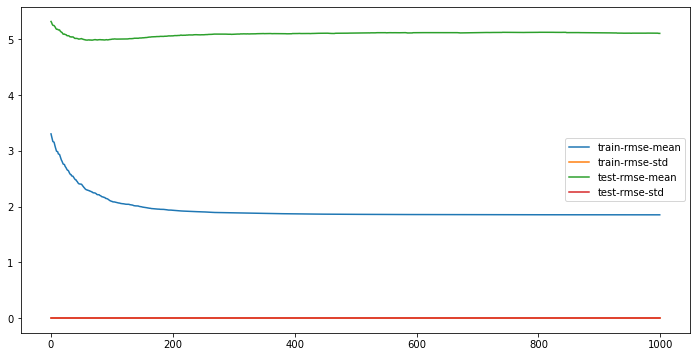

In [44]:
import xgboost as xgb

xgtrain = xgb.DMatrix(data=train[features].values,
                      label=train[target].values)

parameters = {"eta":0.03,
              "gamma":0.3,
              "max_depth":36,
              "min_child_weight":1,
              "subsample":0.9,
              "colsample_bytree":0.9,
              "tree_method":"hist"}

num_boost_round = 1000
metric = "rmse"
early_stopping_rounds = None

cv_model = xgb.cv(params=parameters, 
                  dtrain=xgtrain,
                  num_boost_round=num_boost_round,
                  folds=folds2,
                  metrics=metric,
                  early_stopping_rounds=early_stopping_rounds,
                  verbose_eval=True,
                  seed=42)

cv_model.plot.line(figsize=(12,6))

In [20]:
features__me

['shop_item__me', 'shop_category__me', 'category_item__me']

In [35]:
model.fit(X=train[features + ["shop_item__me", "shop_category__me", "category_item__me"]],
          y=train[target],)

[11:00:59] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [36]:
from joblib import dump, load

model_name = "XGBoost_Mean_Enc"

if model is not None:
    dump(model, Path(MODEL_PATH, model_name + ".joblib"))
else:
    model = load(Path(MODEL_PATH, model_name + ".joblib"))

## Predictions

In [37]:
pred = model.predict(test[features + ["shop_item__me", "shop_category__me", "category_item__me"]])
pred = np.clip(pred, 0, 20)

## Submission

In [38]:
submission = pd.DataFrame({"ID":range(pred.shape[0]),
                           "item_cnt_month":pred})

sub_file_name = "submission_" + model_name + ".csv"
sub_file_path = Path(MODEL_PATH, sub_file_name)

submission[["ID", "item_cnt_month"]].to_csv(sub_file_path, index=False)

!kaggle competitions submit -c competitive-data-science-predict-future-sales -f $sub_file_path -m $model_name

100%|███████████████████████████████████████| 3.13M/3.13M [00:04<00:00, 735kB/s]
Successfully submitted to Predict Future Sales